
<a name="top"> <h1>2. FALSOS REEMPLAZOS</h1> <a>


<p>DECISION TREE - FALSOS REEMPLAZOS<br />
<strong>Price to Market Motor</strong><br />



<p style="text-align:right">Miguel D&iacute;az-Mauriño (<em>miguel.diaz@allianz.es</em>)</p>


# Setup notebooks

### General libraries

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import sys
import lightgbm as lgb
import re
import chardet

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Logging

In [2]:
import logging

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

### Load enviroment variables and adding to PYTHONPATH

In [3]:
from dotenv import load_dotenv
load_dotenv('.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.utils import lgbm_feature_importance, decision_tree_model, label_encode_variables, plot_cramer, plot_lgb_importances, asignar_CCAA
# lgbm_feature_importance,
from src.load_functions import get_renames
from src.data_dict import formato, get_import_columns, get_dtypes_dict, get_rename_dict, get_features_model, get_features, get_feature_type, date_format

### Configuration dictionary

In [5]:
df = pd.read_parquet(os.path.join(data_root, 'FR_Tomador.parquet'))

df.head(5)

,POLIZA,APLICA,RAMO,prima_prop,PRIMA_ANT,PAQ_REPORTING,FRENOV,agrupacm,PRIMAN,MOTANUL,FANUL,FIANUL,CLASS_ANUL,Anulada,POLIZAN,APLICAN,CODPOST,POLIZAS_45,AGENTE,DC,SUCURSAL,USO,TOMADOR,TXCANAL,CODMEDP,CATTAG,AGRUPAGENTE,prima_reemplazante,prperiod,SINOCU,N_ANT,N_ACTUAL,Sdadpol_12M,DTO_DEFENSA,PRIMA_DEFENSA_ADPR,CORREDOR_PILOTO,sdad_total3p,sdad_total_tom,anualidad_seguro,Edad_conductor,APTP,rwCoeff_forced,retention,retention_def,Retencion_antes,TechPrice,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,Valor_Mediador_Turismos,Prob_anul,CODMEDP_bnd,Prueba_Piloto_bnd,Super_rentables_bnd,Corredores_bnd,cltv_decile,Aleatorio,Segmentos_sept,segmento_deficiente_bnd,CAPTOTAL_vida,Edad_tomador_bnd,empleados,POL_VIDA,bm_anualidad,BM_cat,IsBMP,Random,Random_22,DEFENDIBLE,bm_ampliado,Stros2,CS,Provincia,m_anul,Sdadpol_12M_anterior,stros_anterior,defendida_SAS,defendida_ant,FR,priman_new_fr,POLIZAR,PAQUETE_REPORTING,paquete_reporting_reempl,polizar_post,tipo_reemplazo,FRFINAL,GARANTIA_1,GARANTIA_2,GARANTIA_3,GARANTIA_4,GARANTIA_5,GARANTIA_6,GARANTIA_7,GARANTIA_8,Gar_missing,MODALIDAD,SEX,ASISTENCIA,COND_TOM,COND_PROP,MATRICULA,CILIND,POTENCIA,CLASEVH,VALORVH,MARCA,MODELO,BASICO,ROBO,DANOS,FRANQUI,PAQUETE,PLAZAS,GRUA,NPROPIETARIO,ID_CLIENTE,FNACI8,FCARN8,FMATRI,ANTIG_VEHICULO,APR_new,TPR_new,APR_old,TPR_old,CANAL_Med,Nombre_Med,Mediador_Principal_Med,MEDIADOR_Med,solicitud_Med,coti_tec_Med,version_coti_Med,poli_Med,Reemplazo_Med,BM_ACTUAL_Med,BM_ACTUAL_pol_Med,Dto_aplicado_coti_Med,Dto_aplicado_poli_Med,tirea_NO_deseado_Med,FP_NO_Anual_Med,diferente_CP_Med,Dcto_coti_CAP_Med,Dcto_coti_VC_Med,Dcto_coti_TRA_Med,Dcto_coti_CAPVC_Med,Dcto_coti_VCTRA_Med,Dcto_poli_CAP_Med,Dcto_poli_VC_Med,Dcto_poli_TRA_Med,Dcto_poli_CAPVC_Med,Dcto_poli_VCTRA_Med,PRIANUALAC_Med,Canc_NB_Med,Canc_RW_Med,Canc_Impag_NB_Med,Canc_Impag_RW_Med,exp_Med,prima_ganada_Med,Sini_tot_Med,Coste_tot_Med,Sini_RC_Med,Coste_RC_Med,Sini_Danos_Med,Coste_Danos_Med,exp_Danos_Med,Desbloqueo_Med,Desbl_FalsoReemp_Med,Desbl_Menores_Med,DEFENDIDA_Med,DEFENDIBLE_Med,Ratio_DEFENSA_Med,Coste_defensa_Med,tot_MEDIADORES_Med,Ratio_Solicitud_Med,Ratio_Cotizacion_Med,Ratio_Reemplazo_Med,Ratio_BM_Med,Ratio_Tirea_No_deseado_Med,Ratio_Diferente_CP_Med,Ratio_Poli_CAP_Med,Ratio_Poli_VC_Med,Ratio_Poli_TRA_Med,Ratio_Canc_NB_Med,Ratio_Canc_RW_Med,Ratio_Canc_impag_NB_Med,Ratio_Canc_impag_RW_Med,Ratio_Coste_Defensa_Med,Ratio_Fracc_Med,Ratio_Desbloqueo_Med,Ratio_Desbl_FalsoReemp_Med,Ratio_Desbl_Menores_Med,desv_Solicitud_Med,desv_Cotizacion_Med,desv_Reemplazo_Med,desv_BM_Med,desv_Tirea_No_deseado_Med,desv_Diferente_CP_Med,desv_Poli_CAP_Med,desv_Poli_VC_Med,desv_Poli_TRA_Med,desv_Canc_NB_Med,desv_Canc_RW_Med,desv_Canc_impag_NB_Med,desv_Canc_impag_RW_Med,desv_Defensa_Med,desv_Coste_Defensa_Med,desv_Fracc_Med,desv_Desbloqueo_Med,desv_Desbl_FalsoReemp_Med,desv_Desbl_Menores_Med
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,"608,47",None,None,None,None,0,0.0,0.0,18006.0,1,28062,29,519,11000,13379484,Agente,28062.0,-Ninguno,None,"0,00","549,10","0,00",1,1,-69.33,0,0.0,0,-23.30,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,None,NaN,None,9,18,NaN,0.0,0.0,N,N,NaN,None,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0.0,Hombre,S,S,S,0669GBF,1560.0,90.0,TURISMO,19100.0,PEUGEOT,308 CONFORT 1.6 HDI 90 5P,S,S,S,S,4,5.0,None,13379484.0,13379484.0,1946-07-20,1968-02-02,2008-02-01,16.0,"608,47","338,95619130502109","608,47","419,3584640900923",D,GARCIA CUERVA JUAN DE DIOS,28062.0,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,2.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.200000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000,4.200000,0.400

In [6]:
df = formato(df)

In [7]:
import_cols = get_import_columns(df)
df = df[import_cols]

187


In [8]:
df.head(2)

,POLIZA,APLICA,RAMO,prima_prop,PRIMA_ANT,PAQ_REPORTING,FRENOV,agrupacm,PRIMAN,FANUL,FIANUL,POLIZAN,APLICAN,AGENTE,DC,SUCURSAL,USO,TOMADOR,TXCANAL,CATTAG,AGRUPAGENTE,prima_reemplazante,prperiod,SINOCU,N_ANT,N_ACTUAL,Sdadpol_12M,DTO_DEFENSA,PRIMA_DEFENSA_ADPR,CORREDOR_PILOTO,sdad_total3p,sdad_total_tom,anualidad_seguro,Edad_conductor,APTP,rwCoeff_forced,retention,retention_def,Retencion_antes,TechPrice,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,Valor_Mediador_Turismos,Prob_anul,CODMEDP_bnd,Prueba_Piloto_bnd,Super_rentables_bnd,Corredores_bnd,cltv_decile,Aleatorio,Segmentos_sept,segmento_deficiente_bnd,CAPTOTAL_vida,Edad_tomador_bnd,empleados,POL_VIDA,bm_anualidad,BM_cat,Random,Random_22,DEFENDIBLE,bm_ampliado,Stros2,CS,Provincia,Sdadpol_12M_anterior,stros_anterior,defendida_SAS,defendida_ant,FR,POLIZAR,PAQUETE_REPORTING,paquete_reporting_reempl,polizar_post,tipo_reemplazo,FRFINAL,GARANTIA_1,GARANTIA_2,GARANTIA_3,GARANTIA_4,GARANTIA_5,GARANTIA_6,GARANTIA_7,GARANTIA_8,Gar_missing,SEX,ASISTENCIA,COND_TOM,COND_PROP,MATRICULA,CILIND,POTENCIA,CLASEVH,VALORVH,MARCA,ROBO,DANOS,FRANQUI,PAQUETE,PLAZAS,GRUA,ID_CLIENTE,FNACI8,FCARN8,FMATRI,ANTIG_VEHICULO,CANAL_Med,Mediador_Principal_Med,solicitud_Med,coti_tec_Med,version_coti_Med,poli_Med,Reemplazo_Med,BM_ACTUAL_Med,BM_ACTUAL_pol_Med,Dto_aplicado_coti_Med,Dto_aplicado_poli_Med,tirea_NO_deseado_Med,FP_NO_Anual_Med,diferente_CP_Med,Dcto_coti_CAP_Med,Dcto_coti_VC_Med,Dcto_coti_TRA_Med,Dcto_coti_CAPVC_Med,Dcto_coti_VCTRA_Med,Dcto_poli_CAP_Med,Dcto_poli_VC_Med,Dcto_poli_TRA_Med,Dcto_poli_CAPVC_Med,Dcto_poli_VCTRA_Med,PRIANUALAC_Med,Canc_NB_Med,Canc_RW_Med,Canc_Impag_NB_Med,Canc_Impag_RW_Med,exp_Med,prima_ganada_Med,Sini_tot_Med,Coste_tot_Med,Sini_RC_Med,Coste_RC_Med,Sini_Danos_Med,Coste_Danos_Med,exp_Danos_Med,Desbloqueo_Med,Desbl_Menores_Med,DEFENDIDA_Med,DEFENDIBLE_Med,Ratio_DEFENSA_Med,Coste_defensa_Med,tot_MEDIADORES_Med,Ratio_Solicitud_Med,Ratio_Cotizacion_Med,Ratio_Reemplazo_Med,Ratio_BM_Med,Ratio_Tirea_No_deseado_Med,Ratio_Diferente_CP_Med,Ratio_Poli_CAP_Med,Ratio_Poli_VC_Med,Ratio_Poli_TRA_Med,Ratio_Canc_NB_Med,Ratio_Canc_RW_Med,Ratio_Canc_impag_NB_Med,Ratio_Canc_impag_RW_Med,Ratio_Coste_Defensa_Med,Ratio_Fracc_Med,Ratio_Desbloqueo_Med,Ratio_Desbl_Menores_Med,desv_Solicitud_Med,desv_Cotizacion_Med,desv_Reemplazo_Med,desv_BM_Med,desv_Tirea_No_deseado_Med,desv_Diferente_CP_Med,desv_Poli_CAP_Med,desv_Poli_VC_Med,desv_Poli_TRA_Med,desv_Canc_NB_Med,desv_Canc_RW_Med,desv_Canc_impag_NB_Med,desv_Canc_impag_RW_Med,desv_Defensa_Med,desv_Coste_Defensa_Med,desv_Fracc_Med,desv_Desbloqueo_Med,desv_Desbl_Menores_Med
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,608.47,NaT,NaT,0,0,28062,29,519,11000,13379484,Agente,-Ninguno,None,0.00,549.10,0.00,1,1,-69.33,0,0.0,0,-23.3,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,NaN,None,9,18,0.0,0.0,N,N,NaN,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,0,0,0,0,0,0,0,0,8,Hombre,S,S,S,0669GBF,1560.0,90.0,TURISMO,19100.0,PEUGEOT,S,S,S,4,5.0,None,13379484.0,1946-07-20,1968-02-02,2008-02-01,16,D,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.20000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000,4.200000,4.200000,NaN,0.974096,NaN,1.193636,NaN,NaN,0.633038,NaN,NaN,NaN,3.991151,4.962810,6.186607,1.235760,3.711911,1.804206,2.349783,2.349783
1,23176348,0,1269,229.09,210.18,112.0,2023-01-03,1020,229.09,NaT,NaT,0,0,6150157,26,615,11200,14236689,Corredor,3-Corredor FIRST,None,0.00,206.10,0.00,1,1,0.00,0,0.0,0,0.0,0.00,15.0,62.0,Menor 130%,NaN,0.769500,0.903698,0.812728,162.687133,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,5.0,Sí,NaN,Resto,None,None,None,None,None,None,None,No

In [9]:
data_types = get_dtypes_dict(df)
df = df.astype(data_types)

In [10]:
get_rename_dict(df)
df= df.rename(columns=get_rename_dict(df))

In [11]:
categorical_features = get_features(df, FEATURE_TYPE = "Cat")
len(categorical_features)

62

In [12]:
numerical_features = get_features(df, FEATURE_TYPE = "Num")
len(numerical_features)

111

In [13]:
feature_types  = get_feature_type(df)
feature_types

{'poliza': 'ID',
 'aplica': 'Cat',
 'ramo': 'Cat',
 'prima_prop_c': 'Num',
 'prima_ant': 'Num',
 'paq_reporting': 'Cat',
 'fecha_poliza': 'Date',
 'agrupacm': 'Cat',
 'prima_neta': 'Num',
 'motivo_anul': 'Cat',
 'fecha_anul': 'Date',
 'fecha_intro_anul': 'Date',
 'class_anul': 'Cat',
 'anulada': 'Cat',
 'polizan': 'ID',
 'aplican': 'ID',
 'codpost': 'Cat',
 'polizas_45': 'Cat',
 'agente': 'Cat',
 'dc': 'Cat',
 'sucursal': 'Cat',
 'uso': 'Cat',
 'tomador': 'ID',
 'txcanal': 'ID',
 'codigo_mediador': 'Cat',
 'categoria_agente': 'Cat',
 'agrupagente': 'Cat',
 'prima_reemplazante': 'Num',
 'prperiod': 'Num',
 'sinocu': 'Num',
 'n_bm_anterior': 'Cat',
 'n_bm_actual': 'Cat',
 'siniestralidad_pol_12m': 'Num',
 'dto_defensa': 'Cat',
 'prima_defensa_adpr': 'Num',
 'corredor_piloto': 'Cat',
 'siniestralidad_pol_ult_3': 'Num',
 'siniestralidad_total_tom': 'Num',
 'anualidad_seguro': 'Cat',
 'edad_conductor': 'Num',
 'aptp_c': 'Cat',
 'rwcoeff_forced': 'Cat',
 'retention': 'Num',
 'retention_def':

In [14]:
df = date_format(df, feature_types)

In [15]:
asignar_CCAA(df)
df = df.drop('provincia', axis=1)

In [16]:
df.head(5)

,poliza,aplica,ramo,prima_prop_c,prima_ant,paq_reporting,fecha_poliza,agrupacm,prima_neta,fecha_anul,fecha_intro_anul,polizan,aplican,agente,dc,sucursal,uso,tomador,txcanal,categoria_agente,agrupagente,prima_reemplazante,prperiod,sinocu,n_bm_anterior,n_bm_actual,siniestralidad_pol_12m,dto_defensa,prima_defensa_adpr,corredor_piloto,siniestralidad_pol_ult_3,siniestralidad_total_tom,anualidad_seguro,edad_conductor,aptp_c,rwcoeff_forced,retention,retention_def,retencion_antes,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,valor_mediador_turismos,prob_anul,codmedp_bnd,prueba_piloto_bnd,super_rentables_bnd,corredores_bnd,cltv_decile,aleatorio,segmentos_sept,segmento_deficiente_bnd,captotal_vida,edad_tomador_bnd,empleados,pol_vida,bm_anualidad,bm_cat,random,random_22,defendible,bm_ampliado,stros2,credit_score,siniestralidad_12m_anterior,siniestralidad_ult_ano,defendida_sas,defendida_ant,fr,polizar,paquete_reporting,paquete_reporting_reempl,polizar_post,tipo_reemplazo,frfinal,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,garantia_missing,sex,asistencia,cond_tom,cond_prop,matricula,cilindrada,potencia,clasevh,valorvh,marca,robo,danos,franquicia,paquete,plazas,grua,id_cliente,fecha_nacimiento,fecha_carnet,fecha_matriculacion,antig_vehiculo,canal_med,mediador_principal_med,solicitud_med,coti_tec_med,version_coti_med,poli_med,reemplazo_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dto_aplicado_poli_med,tirea_no_deseado_med,fp_no_anual_med,diferente_cp_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_coti_tra_med,dcto_coti_capvc_med,dcto_coti_vctra_med,dcto_poli_cap_med,dcto_poli_vc_med,dcto_poli_tra_med,dcto_poli_capvc_med,dcto_poli_vctra_med,prianualac_med,canc_nb_med,canc_rw_med,canc_impag_nb_med,canc_impag_rw_med,exp_med,prima_ganada_med,sini_tot_med,coste_tot_med,sini_rc_med,coste_rc_med,sini_danos_med,coste_danos_med,exp_danos_med,desbloqueo_med,desbl_menores_med,defendida_med,defendible_med,ratio_defensa_med,coste_defensa_med,tot_mediadores_med,ratio_solicitud_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_nb_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_canc_impag_rw_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_bm_med,desv_tirea_no_deseado_med,desv_diferente_cp_med,desv_poli_cap_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_nb_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_canc_impag_rw_med,desv_defensa_med,desv_coste_defensa_med,desv_fracc_med,desv_desbloqueo_med,desv_desbl_menores_med,comunidad_autonoma
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,608.47,NaT,NaT,0,0,28062,29,519,11000,13379484,Agente,-Ninguno,None,0.0,549.10,0.0,1,1,-69.33,0,0.0,0,-23.30,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,NaN,None,9,0.0,0.0,N,N,NaN,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,0,0,0,0,0,0,0,0,8,Hombre,S,S,S,0669GBF,1560,90,TURISMO,19100,PEUGEOT,S,S,S,4,5,None,13379484,1946-07-20,1968-02-02,2008-02-01,16,D,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.200000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000,4.200000,4.200000,NaN,0.974096,NaN,1.193636,NaN,NaN,0.633038,NaN,NaN,NaN,3.991151,4.962810,6.186607,1.235760,3.711911,1.804206,2.349783,2.349783,Desconocida
1,23176348,0,1269,229.09,210.18,112.0,2023-01-03,1020,229.09,NaT,NaT,0,0,6150157,26,615,11200,14236689,Corredor,3-Corredor FIRST,None,0.0,206.10,0.0,1,1,0.00,0,0.0,0,0.00,0.00,15.0,62.

In [17]:
# numerical_features.append('aptp_reporting_old')
# numerical_features.append('aptp_reporting_new')
categorical_features.append('comunidad_autonoma')
categorical_columns = categorical_features.remove('provincia')

In [18]:
selected_features = categorical_features + numerical_features
len(selected_features)

173

### Correlación Numéricas

In [19]:
correlation_matrix = df[numerical_features].corr()
correlation_matrix

,prima_prop_c,prima_ant,prima_neta,prima_reemplazante,prperiod,sinocu,siniestralidad_pol_12m,prima_defensa_adpr,siniestralidad_pol_ult_3,siniestralidad_total_tom,edad_conductor,retention,retention_def,retencion_antes,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,siniestralidad_12m_anterior,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,cilindrada,potencia,valorvh,plazas,antig_vehiculo,mediador_principal_med,solicitud_med,coti_tec_med,version_coti_med,poli_med,reemplazo_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dto_aplicado_poli_med,tirea_no_deseado_med,fp_no_anual_med,diferente_cp_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_coti_tra_med,dcto_coti_capvc_med,dcto_coti_vctra_med,dcto_poli_cap_med,dcto_poli_vc_med,dcto_poli_tra_med,dcto_poli_capvc_med,dcto_poli_vctra_med,prianualac_med,canc_nb_med,canc_rw_med,canc_impag_nb_med,canc_impag_rw_med,exp_med,prima_ganada_med,sini_tot_med,coste_tot_med,sini_rc_med,coste_rc_med,sini_danos_med,coste_danos_med,exp_danos_med,desbloqueo_med,desbl_menores_med,defendida_med,defendible_med,ratio_defensa_med,coste_defensa_med,tot_mediadores_med,ratio_solicitud_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_nb_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_canc_impag_rw_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_bm_med,desv_tirea_no_deseado_med,desv_diferente_cp_med,desv_poli_cap_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_nb_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_canc_impag_rw_med,desv_defensa_med,desv_coste_defensa_med,desv_fracc_med,desv_desbloqueo_med,desv_desbl_menores_med
prima_prop_c,1.000000,0.986924,0.994602,NaN,0.801542,0.034940,0.012546,0.169227,0.092377,0.080999,-0.056594,-0.411400,-0.241468,-0.378149,0.808299,0.191657,0.047847,0.143650,0.018797,-0.011650,0.088693,0.135329,0.106211,0.219751,0.391643,NaN,NaN,0.183003,0.431742,0.449162,0.030626,-0.250507,-0.009201,0.004037,-0.015951,-0.000502,-0.035105,0.002712,0.057737,0.065625,-0.070186,-0.071375,-0.011893,-0.013928,-0.020429,0.000772,-0.016782,-0.040414,-0.007580,-0.027963,-0.009431,-0.007228,-0.067158,-0.053514,-0.040309,0.001325,NaN,-0.048090,-0.027488,-0.031114,-0.032986,0.001367,-0.009174,-0.006350,-0.007847,0.005198,0.021604,0.019371,-0.000615,-0.015856,-0.031299,-0.048943,-0.042977,-0.024820,-0.033353,0.014347,0.000933,0.005646,0.019483,0.065625,0.081845,0.050438,0.068415,0.038392,-0.055482,NaN,0.004352,0.003337,0.008773,0.017408,0.055267,0.022538,0.022538,0.013248,0.026055,0.007285,0.069054,0.085077,0.012374,0.056621,0.046211,-0.026010,NaN,-0.003104,0.001960,-0.005058,-0.011584,0.020634,0.056325,0.031429,0.031429
prima_ant,0.986924,1.000000,0.980841,NaN,0.818235,0.030148,0.000120,0.192421,0.054621,0.048643,-0.048008,-0.350900,-0.184406,-0.347660,0.770793,0.138733,0.022384,0.094271,0.012453,-0.014212,0.075563,0.133998,0.108070,0.226755,0.383694,NaN,NaN,0.184503,0.439249,0.457536,0.029766,-0.249784,-0.003994,0.007108,-0.015627,0.001021,-0.034346,0.004638,0.053146,0.062640,-0.071015,-0.072991,-0.011697,-0.013834,-0.021047,0.002309,-0.017874,-0.028629,-0.005531,-0.020568,-0.008646,-0.012065,-0.054728,-0.054330,-0.039966,0.002348,NaN,-0.047626,-0.028248,-0.031271,-0.031664,0.003171,-0.008046,-0.005406,-0.007213,0.005296,0.023745,0.022076,0.003520,-0.015895,-0.030043,-0.049357,-0.041221,-0.029610,-0.032394,0.015742,0.004964,0.002834,0.018845,0.062640,0.081042,0.045707,0.068667,0.038172,-0.067034,NaN,0.004790,0.002300,0.008328,0.020287,0.052717,0.023012,0.023012,0.013104,0.026385,0.012754,0.065701,0.082849,0.012322,0.057556,0.046607,-0.035487,NaN,-0.002013,0.001296,-0.005549,-0.015956,0.024237,0.054650,0.033408,0.033408
prima_neta,0.994602,0.980841,1.000000,NaN,0.824466,0.036000,0.013668,0.127071,0.094992,0.082

In [20]:
df2 = pd.DataFrame(correlation_matrix.unstack(), columns=["Correlation"])
df2 = df2[~(df2["Correlation"] == 1)].abs().sort_values(by="Correlation", ascending=False)
df2.head(20)

Correlation
prianualac_med       reemplazo_med            1.000000
reemplazo_med        prianualac_med           1.000000
version_coti_med     dcto_coti_cap_med        0.998257
dcto_coti_cap_med    version_coti_med         0.998257
prima_neta           prima_prop_c             0.994602
prima_prop_c         prima_neta               0.994602
ratio_bm_med         desv_bm_med              0.988505
desv_bm_med          bm_actual_pol_med        0.988505
                     ratio_bm_med             0.988505
bm_actual_pol_med    desv_bm_med              0.988505
prima_prop_c         prima_ant                0.986924
prima_ant            prima_prop_c             0.986924
                     prima_neta               0.980841
prima_neta           prima_ant                0.980841
ratio_fracc_med      desv_fracc_med           0.974219
desv_fracc_med       ratio_fracc_med          0.974219
tirea_no_deseado_med dcto_poli_cap_med        0.968651
dcto_poli_cap_med    tirea_no_deseado_med     0.968651
ratio_defensa_med    desv_defensa_med         0.963670
desv_defensa_med     ratio_defensa_med        0.963670

In [21]:
df2[df2.Correlation >= 0.85]

,,Correlation
prianualac_med,reemplazo_med,1.000000
reemplazo_med,prianualac_med,1.000000
version_coti_med,dcto_coti_cap_med,0.998257
dcto_coti_cap_med,version_coti_med,0.998257
prima_neta,prima_prop_c,0.994602
...,...,...
fp_no_anual_med,diferente_cp_med,0.854870
valorvh,potencia,0.854811
potencia,valorvh,0.854811
diferente_cp_med,solicitud_med,0.853362


In [22]:
pd.set_option('display.max_rows', 500)
df2.head(100)

Correlation
prianualac_med             reemplazo_med                  1.000000
reemplazo_med              prianualac_med                 1.000000
version_coti_med           dcto_coti_cap_med              0.998257
dcto_coti_cap_med          version_coti_med               0.998257
prima_neta                 prima_prop_c                   0.994602
prima_prop_c               prima_neta                     0.994602
ratio_bm_med               desv_bm_med                    0.988505
desv_bm_med                bm_actual_pol_med              0.988505
                           ratio_bm_med                   0.988505
bm_actual_pol_med          desv_bm_med                    0.988505
prima_prop_c               prima_ant                      0.986924
prima_ant                  prima_prop_c                   0.986924
                           prima_neta                     0.980841
prima_neta                 prima_ant                      0.980841
ratio_fracc_med            desv_fracc_med                 0.974219
desv_fracc_med             ratio_fracc_med                0.974219
tirea_no_deseado_med       dcto_poli_cap_med              0.968651
dcto_poli_cap_med          tirea_no_deseado_med           0.968651
ratio_defensa_med          desv_defensa_med               0.963670
desv_defensa_med           ratio_defensa_med              0.963670
dcto_coti_tra_med          coti_tec_med                   0.962748
coti_tec_med               dcto_coti_tra_med              0.962748
tirea_no_deseado_med       fp_no_anual_med                0.962400
fp_no_anual_med            tirea_no_deseado_med           0.962400
version_coti_med           dcto_coti_tra_med              0.960029
dcto_coti_tra_med          version_coti_med               0.960029
sini_tot_med               exp_med                        0.959772
exp_med                    sini_tot_med                   0.959772
desv_canc_impag_rw_med     desv_canc_rw_med               0.954933
desv_canc_rw_med           desv_canc_impag_rw_med         0.954933
ratio_canc_rw_med          ratio_canc_impag_rw_med        0.954450
ratio_canc_impag_rw_med    ratio_canc_rw_med              0.954450
ratio_canc_impag_nb_med    desv_canc_impag_nb_med         0.953347
desv_canc_impag_nb_med     ratio_canc_impag_nb_med        0.953347
retention                  retencion_antes                0.951657
retencion_antes            retention                      0.951657
dcto_poli_cap_med          solicitud_med                  0.950704
solicitud_med              dcto_poli_cap_med              0.950704
tirea_no_deseado_med       solicitud_med                  0.949486
solicitud_med              tirea_no_deseado_med           0.949486
sini_rc_med                sini_tot_med                   0.947970
sini_tot_med               sini_rc_med                    0.947970
ratio_poli_cap_med         desv_poli_cap_med              0.943280
desv_poli_cap_med          ratio_poli_cap_med             0.943280
poli_med                   tirea_no_deseado_med           0.941916
tirea_no_deseado_med       poli_med                       0.941916
poli_med                   solicitud_med                  0.941811
solicitud_med              poli_med                       0.941811
ratio_tirea_no_deseado_med desv_tirea_no_deseado_med      0.940686
desv_tirea_no_deseado_med  ratio_tirea_no_deseado_med     0.940686
sini_rc_med                prima_ganada_med               0.939263
prima_ganada_med           sini_rc_med                    0.939263
reemplazo_med              dcto_coti_capvc_med            0.934937
dcto_coti_capvc_med        reemplazo_med                  0.934937
canc_rw_med                exp_med                        0.932600
exp_med                    canc_rw_med                    0.932600
dcto_coti_cap_med          solicitud_med                  0.932086
solicitud_med              dcto_coti_cap_med              0.932086
canc_rw_med                canc_impag_rw_med              0.930838
canc_impag_rw_med          canc_rw_

In [23]:
df2.iloc[100:151]

,,Correlation
dcto_coti_vctra_med,dcto_poli_capvc_med,0.896241
dcto_poli_capvc_med,dcto_coti_vctra_med,0.896241
ratio_solicitud_med,ratio_cotizacion_med,0.894936
ratio_cotizacion_med,ratio_solicitud_med,0.894936
prima_ganada_med,exp_med,0.892638
exp_med,prima_ganada_med,0.892638
dto_aplicado_coti_med,dto_aplicado_poli_med,0.891556
dto_aplicado_poli_med,dto_aplicado_coti_med,0.891556
coti_tec_med,solicitud_med,0.889359
solicitud_med,coti_tec_med,0.889359


#### Eliminación de variables en base a la CORR

In [24]:
# Lista de columnas para eliminar
columns_to_drop = ['prima_prop_c', 'prima_ant', 'prperiod', 'retencion_antes', 'retention_def', 'potencia',
                   'reemplazo_med', 'version_coti_med', 'desv_bm_med', 'desv_fracc_med', 'tirea_no_deseado_med',
                   'desv_defensa_med', 'dcto_coti_tra_med', 'sini_tot_med', 'dcto_coti_tra_med', 'desv_canc_impag_rw_med',
                   'ratio_canc_impag_rw_med', 'solicitud_med', 'sini_rc_med', 'desv_poli_cap_med', 'desv_tirea_no_deseado_med',
                   'dcto_coti_capvc_med', 'canc_rw_med', 'fp_no_anual_med', 'coste_defensa_med', 'dcto_coti_vctra_med',
                   'sini_tot_med', 'dcto_poli_cap_med', 'desv_desbloqueo_med', 'desv_desbl_menores_med',
                   'diferente_cp_med', 'coste_danos_med', 'desbl_menores_med', 'canc_impag_nb_med', 'dto_aplicado_poli_med',
                   'prima_ganada_med', 'ratio_solicitud_med', 'dcto_coti_vctra_med', 'dcto_poli_tra_med']

### Queda pdte Tech Price

# Numerical
numerical_features_1 = [column for column in numerical_features if column not in columns_to_drop]

if len(numerical_features_1) == len(numerical_features):
    print("All columns to drop are present in numerical_features.")
else:
    removed_columns = [column for column in numerical_features if column in columns_to_drop]
    print(f"{removed_columns} has been removed in numerical_features.")

# Categorical
categorical_features_1 = [column for column in categorical_features if column not in columns_to_drop]

if len(categorical_features_1) == len(categorical_features):
    print("All columns to drop are present in categorical_features.")
else:
    removed_columns = [column for column in categorical_features if column in columns_to_drop]
    print(f"{removed_columns} has been removed in categorical_features.")

# Eliminar las columnas
df = df.drop(columns_to_drop, axis=1)

['prima_prop_c', 'prima_ant', 'prperiod', 'retention_def', 'retencion_antes', 'potencia', 'solicitud_med', 'version_coti_med', 'reemplazo_med', 'dto_aplicado_poli_med', 'tirea_no_deseado_med', 'fp_no_anual_med', 'diferente_cp_med', 'dcto_coti_tra_med', 'dcto_coti_capvc_med', 'dcto_coti_vctra_med', 'dcto_poli_cap_med', 'dcto_poli_tra_med', 'canc_rw_med', 'canc_impag_nb_med', 'prima_ganada_med', 'sini_tot_med', 'sini_rc_med', 'coste_danos_med', 'desbl_menores_med', 'coste_defensa_med', 'ratio_solicitud_med', 'ratio_canc_impag_rw_med', 'desv_bm_med', 'desv_tirea_no_deseado_med', 'desv_poli_cap_med', 'desv_canc_impag_rw_med', 'desv_defensa_med', 'desv_fracc_med', 'desv_desbloqueo_med', 'desv_desbl_menores_med'] has been removed in numerical_features.
All columns to drop are present in categorical_features.


### Valores NaN

In [25]:
# Supongamos que df es tu DataFrame original
nan_counts = df.isna().sum()
# Convierte la serie en un DataFrame
nan_counts_df = pd.DataFrame(nan_counts, columns=['Number of NaN'])
# Calcula el porcentaje y crea una nueva columna
nan_counts_df['Percentage'] = nan_counts_df['Number of NaN'] / len(df) * 100
nan_counts_df['Percentage'] = nan_counts_df['Percentage'].round()

nan_counts_df.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
canc_nb_med,1599390,100.0
ratio_canc_nb_med,1599390,100.0
desv_canc_nb_med,1599390,100.0
segmentos_sept,1599390,100.0
grua,1598231,100.0
tipo_reemplazo,1589691,99.0
paquete_reporting_reempl,1589683,99.0
fr,1581412,99.0
dcto_poli_vctra_med,1579946,99.0
desv_solicitud_med,1486284,93.0


#### Valores NaN en Numericas

In [26]:
nan_counts1 = df[numerical_features_1].isna().sum()

nan_counts_df1 = pd.DataFrame(nan_counts1, columns=['Number of NaN'])
# Calcula el porcentaje 
nan_counts_df1['Percentage'] = nan_counts_df1['Number of NaN'] / len(df) * 100
nan_counts_df1['Percentage'] = nan_counts_df1['Percentage'].round()

nan_counts_df1.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
ratio_canc_nb_med,1599390,100.0
canc_nb_med,1599390,100.0
desv_canc_nb_med,1599390,100.0
dcto_poli_vctra_med,1579946,99.0
desv_solicitud_med,1486284,93.0
desv_poli_tra_med,1470138,92.0
ratio_poli_tra_med,1470138,92.0
desv_reemplazo_med,1110771,69.0
ratio_reemplazo_med,1110771,69.0
retention,1075910,67.0


#### Reemplazamos valores nulos por la mediana

In [27]:
df[numerical_features_1] = df[numerical_features_1].fillna(df[numerical_features_1].median())

#### Valores NaN en Categoricas

In [28]:
nan_counts2 = df[categorical_features_1].isna().sum()

nan_counts_df2 = pd.DataFrame(nan_counts2, columns=['Number of NaN'])
# Calcula el porcentaje
nan_counts_df2['Percentage'] = nan_counts_df2['Number of NaN'] / len(df) * 100
nan_counts_df2['Percentage'] = nan_counts_df2['Percentage'].round()

nan_counts_df2.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
segmentos_sept,1599390,100.0
grua,1598231,100.0
tipo_reemplazo,1589691,99.0
paquete_reporting_reempl,1589683,99.0
fr,1581412,99.0
bm_ampliado,1478294,92.0
random_22,1473975,92.0
rwcoeff_forced,1464396,92.0
danos,1387836,87.0
robo,1387836,87.0


#### Eliminación de variables en base a NaN

In [29]:
# Lista de columnas para eliminar
columns_to_drop_1 = ['segmentos_sept', 'random_22', 'random', 'fr', 'grua', 'tipo_reemplazo', 'paquete_reporting_reempl',
                     'canc_nb_med', 'desv_canc_nb_med', 'ratio_canc_nb_med', 'dcto_poli_vctra_med']

# Numerical
numerical_features_2 = [column for column in numerical_features_1 if column not in columns_to_drop_1]

if len(numerical_features_2) == len(numerical_features_1):
    print("All columns to drop are present in numerical_features.")
else:
    removed_columns = [column for column in numerical_features_1 if column in columns_to_drop_1]
    print(f"{removed_columns} has been removed in numerical_features.")

# Categorical
categorical_features_2 = [column for column in categorical_features_1 if column not in columns_to_drop_1]

if len(categorical_features_2) == len(categorical_features_1):
    print("All columns to drop are present in categorical_features.")
else:
    removed_columns = [column for column in categorical_features_1 if column in columns_to_drop_1]
    print(f"{removed_columns} has been removed in categorical_features.")

# Eliminar las columnas
df = df.drop(columns_to_drop_1, axis=1)

['dcto_poli_vctra_med', 'canc_nb_med', 'ratio_canc_nb_med', 'desv_canc_nb_med'] has been removed in numerical_features.
['segmentos_sept', 'random', 'random_22', 'fr', 'paquete_reporting_reempl', 'tipo_reemplazo', 'grua'] has been removed in categorical_features.


In [30]:
print(len(categorical_features_1))
print(len(categorical_features_2))

62
55


### Correlación Categóricas

In [31]:
#cramer = plot_cramer(df[categorical_features_2])

#### Creamos valor '999' para reemplazar valores nulos

In [31]:
df['defendible'] = df['defendible'].fillna('N')
df['empleados'] = df['empleados'].fillna('Resto')
df['captotal_Vida'] = df['captotal_vida'].fillna('Resto')

df['anualidad_seguro'] = df['anualidad_seguro'].fillna(999.0)
df['rwcoeff_forced'] = df['rwcoeff_forced'].fillna(999.0)
df['prueba_piloto_bnd'] = df['prueba_piloto_bnd'].fillna(999.0)
df['cltv_decile'] = df['cltv_decile'].fillna(999.0)
df['bm_ampliado'] = df['bm_ampliado'].fillna(999.0)
df['siniestralidad_ult_ano'] = df['siniestralidad_ult_ano'].fillna(999.0)

In [32]:
df[categorical_features_2] = df[categorical_features_2].fillna('999 - NaN')

In [33]:
selected_features_2 = numerical_features_2 + categorical_features_2

In [35]:
### Borrar

### Prueba TPR

In [36]:
df_TP = df[['poliza', 'frenov', 'aptp_c', 'tp_c', 'apr_new', 'tpr_new', 'aptp_reporting_new', 'apr_old', 'tpr_old', 'aptp_reporting_old']]

KeyError: "['frenov', 'apr_new', 'tpr_new', 'aptp_reporting_new', 'apr_old', 'tpr_old', 'aptp_reporting_old'] not in index"

#### Modelo Nuevo (Nov - Dic)

In [ ]:
df_TP[['poliza', 'frenov', 'aptp_c', 'tp_c', 'apr_new', 'tpr_new', 'aptp_reporting_new']][df_TP.frenov == '2023-01-11']

In [ ]:
df_TP[['poliza', 'frenov', 'aptp_c', 'tp_c', 'apr_new', 'tpr_new', 'aptp_reporting_new']][df_TP.frenov == '2023-01-12']

#### Modelo Old (Ene - Oct)

In [ ]:
df_TP[['frenov', 'aptp_c', 'tp_c', 'apr_old', 'tpr_old', 'aptp_reporting_old']][df_TP.frenov == '2023-01-01']

In [ ]:
df_TP[['frenov', 'aptp_c', 'tp_c', 'apr_old', 'tpr_old', 'aptp_reporting_old']][df_TP.frenov == '2023-01-09']

### Agrupación de Agente

In [37]:
len(df[(df['frfinal'] == 1) & (df['defendible'] == 'S') & (df.agente == 7850055)])

17

In [38]:
unique_agente = df['agente'].unique()

# Create a new DataFrame with unique values of "agente"
df_agentes = pd.DataFrame(unique_agente, columns=['agente'])

count_frfinal = df[df['frfinal'] == 1]['agente'].value_counts()
df_agentes['frfinal_count'] = df_agentes['agente'].map(count_frfinal).fillna(0)
df_agentes['frfinal_count'] = df_agentes['frfinal_count'].astype(int)

count_agente = df['agente'].value_counts()
df_agentes['agente_count'] = df_agentes['agente'].map(count_agente).fillna(0)

df_agentes['% fr'] = (df_agentes['frfinal_count'] / df_agentes['agente_count']) * 100
df_agentes['% fr'] = df_agentes['% fr'].round(2)

filtered_df = df[(df['frfinal'] == 1) & (df['defendible'] == 'S')]
counts = filtered_df.groupby('agente').size()
df_agentes['count_FR_defendible_S'] = df_agentes['agente'].map(counts)
df_agentes['count_FR_defendible_S'] = df_agentes['count_FR_defendible_S'].fillna(0).astype(int)

df_agentes['Percentage BBDD'] = df_agentes['agente_count'] / len(df) * 100
df_agentes['Percentage BBDD'] = df_agentes['Percentage BBDD'].round(2)

df_agentes['Percentage FR'] = df_agentes['frfinal_count'] / len(df[df.frfinal == 1]) * 100
df_agentes['Percentage FR'] = df_agentes['Percentage FR'].round(4)

In [39]:
df_agentes = df_agentes.sort_values(by=['frfinal_count'], ascending=False)
df_agentes['Cumulative FR %'] = df_agentes['Percentage FR'].cumsum()
df_agentes['Cumulative %'] = df_agentes['Percentage BBDD'].cumsum()
df_agentes.head(30)

,agente,frfinal_count,agente_count,% fr,count_FR_defendible_S,Percentage BBDD,Percentage FR,Cumulative FR %,Cumulative %
148,7850055,155,3040,5.10,17,0.19,1.1889,1.1889,0.19
525,8700278,116,2380,4.87,8,0.15,0.8898,2.0787,0.34
1842,8250244,102,1178,8.66,15,0.07,0.7824,2.8611,0.41
328,7602511,73,1189,6.14,5,0.07,0.5599,3.4210,0.48
1592,7101046,72,1170,6.15,1,0.07,0.5523,3.9733,0.55
935,15238,69,2194,3.14,0,0.14,0.5293,4.5026,0.69
3573,17462,65,1207,5.39,6,0.08,0.4986,5.0012,0.77
62,8700344,65,3227,2.01,2,0.20,0.4986,5.4998,0.97
5,5230382,61,5987,1.02,0,0.37,0.4679,5.9677,1.34
1644,37153,61,101,60.40,3,0.01,0.4679,6.4356,1.35


In [40]:
print(len(df_agentes[df_agentes['Cumulative FR %'] <= 50]))
print(len(df_agentes))
result = (len(df_agentes[df_agentes['Cumulative FR %'] <= 50]) / len(df_agente)) * 100
print("{:.2f}%".format(result) +'\n')
print(df_agentes.iloc[:350]['frfinal_count'].sum())
print(df_agentes['frfinal_count'].sum())
FR = (df_agentes.iloc[:350]['frfinal_count'].sum() / df_agentes['frfinal_count'].sum()) *100
print("{:.2f}%".format(FR))

345
9989
3.45%

6561
13037
50.33%


In [41]:
df_agentes.iloc[340:350]

,agente,frfinal_count,agente_count,% fr,count_FR_defendible_S,Percentage BBDD,Percentage FR,Cumulative FR %,Cumulative %
1049,5470039,9,312,2.88,0,0.02,0.069,49.7048,17.59
1764,1071509,9,646,1.39,0,0.04,0.069,49.7738,17.63
2195,9450024,9,886,1.02,0,0.06,0.069,49.8428,17.69
6872,30219,9,135,6.67,0,0.01,0.069,49.9118,17.70
377,8250021,9,288,3.12,0,0.02,0.069,49.9808,17.72
2077,7600141,9,198,4.55,1,0.01,0.069,50.0498,17.73
2494,9450029,9,766,1.17,0,0.05,0.069,50.1188,17.78
8045,33289,9,467,1.93,0,0.03,0.069,50.1878,17.81
6145,26173,9,156,5.77,1,0.01,0.069,50.2568,17.82
4786,850186,9,406,2.22,1,0.03,0.069,50.3258,17.85


In [42]:
df_agentes[df_agentes['% fr'] >= 20]

,agente,frfinal_count,agente_count,% fr,count_FR_defendible_S,Percentage BBDD,Percentage FR,Cumulative FR %,Cumulative %
1644,37153,61,101,60.40,3,0.01,0.4679,6.4356,1.35
1631,3350989,38,189,20.11,4,0.01,0.2915,11.8049,2.58
9761,38891,3,14,21.43,0,0.00,0.0230,79.9708,39.39
5705,21811,3,13,23.08,0,0.00,0.0230,80.9138,40.21
8151,38965,2,5,40.00,0,0.00,0.0153,87.1051,46.49
9754,38848,2,6,33.33,0,0.00,0.0153,90.1345,50.61
3602,37243,1,3,33.33,0,0.00,0.0077,90.4959,51.40
9757,38812,1,5,20.00,1,0.00,0.0077,91.4353,52.88
9923,39016,1,5,20.00,0,0.00,0.0077,93.4989,56.15
9818,5710034,1,1,100.00,1,0.00,0.0077,95.5856,59.00


### Analisis por Principal

In [43]:
unique_principal = df['mediador_principal_med'].unique()

df_principal = pd.DataFrame(unique_principal, columns=['mediador_principal_med'])

count_frfinal_p = df[df['frfinal'] == 1]['mediador_principal_med'].value_counts()
df_principal['frfinal_count'] = df_principal['mediador_principal_med'].map(count_frfinal_p).fillna(0)
df_principal['frfinal_count'] = df_principal['frfinal_count'].astype(int)

count_principal = df['mediador_principal_med'].value_counts()
df_principal['principal_count'] = df_principal['mediador_principal_med'].map(count_principal).fillna(0)

df_principal['% fr'] = (df_principal['frfinal_count'] / df_principal['principal_count']) * 100
df_principal['% fr'] = df_principal['% fr'].round(2)

filtered_df_p = df[(df['frfinal'] == 1) & (df['defendible'] == 'S')]
counts = filtered_df_p.groupby('mediador_principal_med').size()
df_principal['count_FR_defendible_S'] = df_principal['mediador_principal_med'].map(counts)
df_principal['count_FR_defendible_S'] = df_principal['count_FR_defendible_S'].fillna(0).astype(int)

df_principal['Percentage BBDD'] = df_principal['principal_count'] / len(df) * 100
df_principal['Percentage BBDD'] = df_principal['Percentage BBDD'].round(2)

df_principal['Percentage FR'] = df_principal['frfinal_count'] / len(df[df.frfinal == 1]) * 100
df_principal['Percentage FR'] = df_principal['Percentage FR'].round(4)

In [44]:
df_principal = df_principal.sort_values(by=['frfinal_count'], ascending=False)
df_principal['Cumulative FR %'] = df_principal['Percentage FR'].cumsum()
df_principal['Cumulative %'] = df_principal['Percentage BBDD'].cumsum()
df_principal.head(30)

,mediador_principal_med,frfinal_count,principal_count,% fr,count_FR_defendible_S,Percentage BBDD,Percentage FR,Cumulative FR %,Cumulative %
148,7850055.0,171,3189,5.36,18,0.20,1.3117,1.3117,0.20
507,8700278.0,119,2536,4.69,8,0.16,0.9128,2.2245,0.36
1686,8250244.0,119,1356,8.78,19,0.08,0.9128,3.1373,0.44
5,5230382.0,82,8458,0.97,0,0.53,0.6290,3.7663,0.97
321,7602511.0,73,1224,5.96,5,0.08,0.5599,4.3262,1.05
1469,7101046.0,72,1170,6.15,1,0.07,0.5523,4.8785,1.12
886,15238.0,69,2194,3.14,0,0.14,0.5293,5.4078,1.26
3153,17462.0,69,1283,5.38,6,0.08,0.5293,5.9371,1.34
124,14925.0,68,1558,4.36,1,0.10,0.5216,6.4587,1.44
1515,18128.0,66,358,18.44,4,0.02,0.5063,6.9650,1.46


In [45]:
print(len(df[df.agente == 7850055]))
print(len(df[(df.agente == 7850055) & (df.frfinal == 1)]))

3040
155


In [ ]:
### Borrar

#### Creación Variable Random para ver si tiene relevancia en el Feature

In [34]:
df['random_column'] = np.random.rand(len(df))

#### Guardar PQ & CSV

In [ ]:
#df.to_parquet(os.path.join(data_root, "202312_FR_BBDD.pq"))
#df.to_csv(os.path.join(data_root, "202312_FR_BBDD.csv"))

## Feature Importance

In [35]:
categorical_columns = categorical_features.remove('frfinal')

In [36]:
DF = df[selected_features_2].copy()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10430, number of negative: 1269082
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.442993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16002
[LightGBM] [Info] Number of data points in the train set: 1279512, number of used features: 118
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008152 -> initscore=-4.801363
[LightGBM] [Info] Start training from score -4.801363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

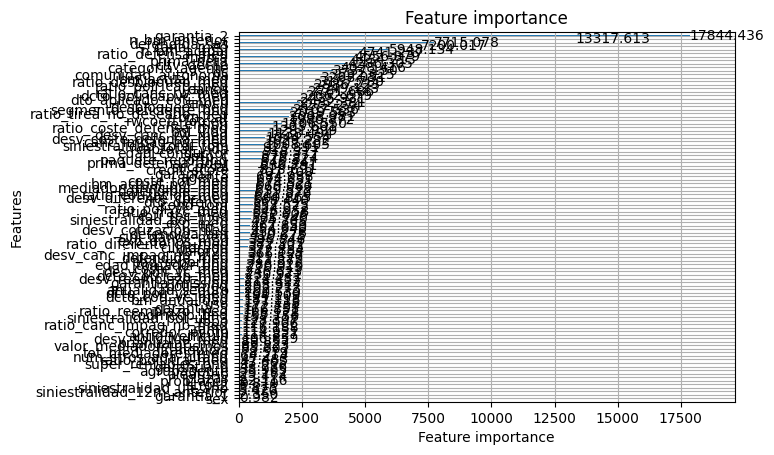

In [37]:
top_30_features, df_selected = lgbm_feature_importance(DF, "frfinal")

In [38]:
top_30_features.head(10)

,Value,Feature
124,257,marca
123,143,garantia_2
122,86,comunidad_autonoma
121,83,ratio_defensa_med
120,76,segmento_deficiente_bnd
119,73,ratio_desbloqueo_med
118,73,prima_neta
117,68,defendida_sas
116,67,bm_actual_med
115,58,desbloqueo_med


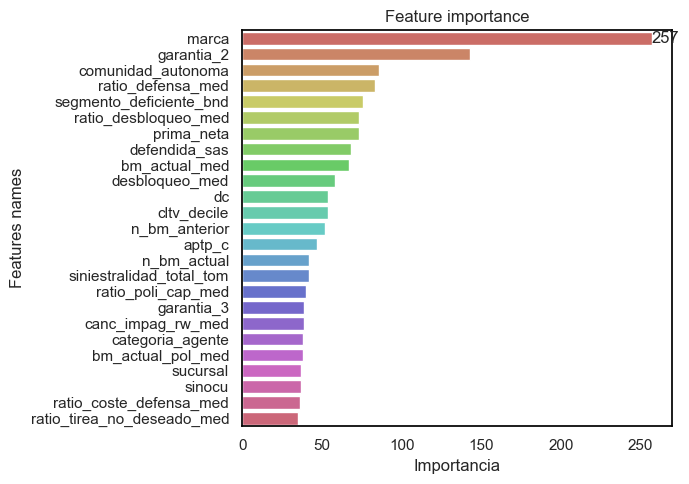

In [39]:
plot_lgb_importances(top_30_features, plot=True)

# Decision Tree

In [40]:
columns_to_select = list(set(df_selected.columns).intersection(categorical_features_2))
categorical_vars = df[columns_to_select].columns.tolist()
print(len(categorical_vars))
categorical_vars

11


['n_bm_actual',
 'comunidad_autonoma',
 'sucursal',
 'aptp_c',
 'segmento_deficiente_bnd',
 'categoria_agente',
 'n_bm_anterior',
 'cltv_decile',
 'defendida_sas',
 'dc',
 'marca']

In [41]:
df_encoded = label_encode_variables(df_selected, categorical_vars)
df_encoded_all = label_encode_variables(df, categorical_features_2)

df_encoded.head(5)

,marca,garantia_2,comunidad_autonoma,ratio_defensa_med,segmento_deficiente_bnd,ratio_desbloqueo_med,prima_neta,defendida_sas,bm_actual_med,desbloqueo_med,dc,cltv_decile,n_bm_anterior,aptp_c,n_bm_actual,siniestralidad_total_tom,ratio_poli_cap_med,garantia_3,canc_impag_rw_med,categoria_agente,bm_actual_pol_med,sucursal,sinocu,ratio_coste_defensa_med,ratio_tirea_no_deseado_med,n_bm_actual_LabelEncoded,comunidad_autonoma_LabelEncoded,sucursal_LabelEncoded,aptp_c_LabelEncoded,segmento_deficiente_bnd_LabelEncoded,categoria_agente_LabelEncoded,n_bm_anterior_LabelEncoded,cltv_decile_LabelEncoded,defendida_sas_LabelEncoded,dc_LabelEncoded,marca_LabelEncoded
0,PEUGEOT,0,Desconocida,0.421769,Resto,4.200000,608.47,N,9.222222,21.0,29,8.0,1,Menor 160%,1,-14.83,0.200000,0,62.0,-Ninguno,6.600000,519,0.0,414.068000,0.166667,1,0,28,9,28,0,1,7,1,7,246
1,RENAULT,0,comunidad_valenciana,0.318293,Resto,0.886022,229.09,N,9.832578,412.0,26,5.0,1,Menor 130%,1,0.00,0.879570,0,418.0,3-Corredor FIRST,3.815054,615,0.0,12.879419,0.116129,1,11,47,6,28,2,1,4,1,4,266
2,OPEL,0,Desconocida,0.476021,Resto,1.194444,335.54,N,8.835777,86.0,28,8.0,1,Menor 250%,1,0.00,0.513889,0,25.0,V-Agente excelente a¦o en curso,7.222222,335,0.0,118.345694,0.319444,1,0,12,15,28,10,1,7,1,6,241
3,PEUGEOT,0,melilla,0.459893,Resto,3.772727,332.16,N,6.873469,166.0,21,8.0,1,Menor 190%,2,55.40,0.363636,0,66.0,V-Agente excelente a¦o en curso,4.477273,470,0.0,256.757727,0.181818,2,15,18,12,28,10,1,7,1,0,246
4,NISSAN,0,Desconocida,0.423529,Resto,1.074074,263.26,N,8.090164,29.0,22,5.0,1,Menor 200%,1,0.00,0.481481,0,38.0,P-Corredor PLUS,4.592593,543,0.0,88.224444,0.148148,1,0,36,13,28,9,1,4,1,1,237


In [42]:
df_encoded_VF = df_encoded.copy()
df_encoded_VF = df_encoded_VF.drop(categorical_vars, axis=1)
df_encoded_VF.head(5)

,garantia_2,ratio_defensa_med,ratio_desbloqueo_med,prima_neta,bm_actual_med,desbloqueo_med,siniestralidad_total_tom,ratio_poli_cap_med,garantia_3,canc_impag_rw_med,bm_actual_pol_med,sinocu,ratio_coste_defensa_med,ratio_tirea_no_deseado_med,n_bm_actual_LabelEncoded,comunidad_autonoma_LabelEncoded,sucursal_LabelEncoded,aptp_c_LabelEncoded,segmento_deficiente_bnd_LabelEncoded,categoria_agente_LabelEncoded,n_bm_anterior_LabelEncoded,cltv_decile_LabelEncoded,defendida_sas_LabelEncoded,dc_LabelEncoded,marca_LabelEncoded
0,0,0.421769,4.200000,608.47,9.222222,21.0,-14.83,0.200000,0,62.0,6.600000,0.0,414.068000,0.166667,1,0,28,9,28,0,1,7,1,7,246
1,0,0.318293,0.886022,229.09,9.832578,412.0,0.00,0.879570,0,418.0,3.815054,0.0,12.879419,0.116129,1,11,47,6,28,2,1,4,1,4,266
2,0,0.476021,1.194444,335.54,8.835777,86.0,0.00,0.513889,0,25.0,7.222222,0.0,118.345694,0.319444,1,0,12,15,28,10,1,7,1,6,241
3,0,0.459893,3.772727,332.16,6.873469,166.0,55.40,0.363636,0,66.0,4.477273,0.0,256.757727,0.181818,2,15,18,12,28,10,1,7,1,0,246
4,0,0.423529,1.074074,263.26,8.090164,29.0,0.00,0.481481,0,38.0,4.592593,0.0,88.224444,0.148148,1,0,36,13,28,9,1,4,1,1,237


Accuracy: 0.5435884931129993
AUC: 0.7298750959674503
F1 score: 0.02868776113047875
F2 score: 0.33196066382576994


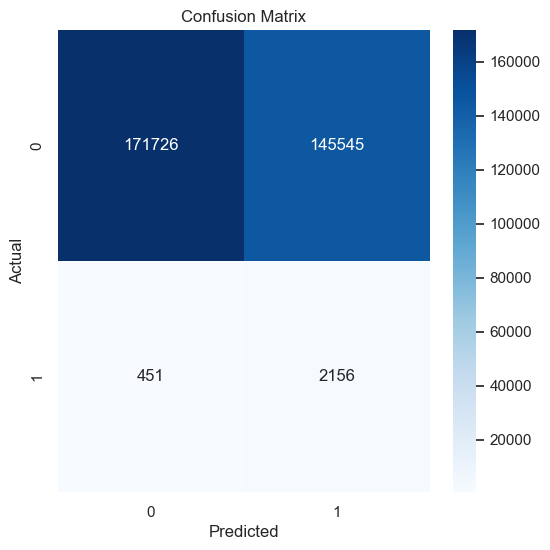

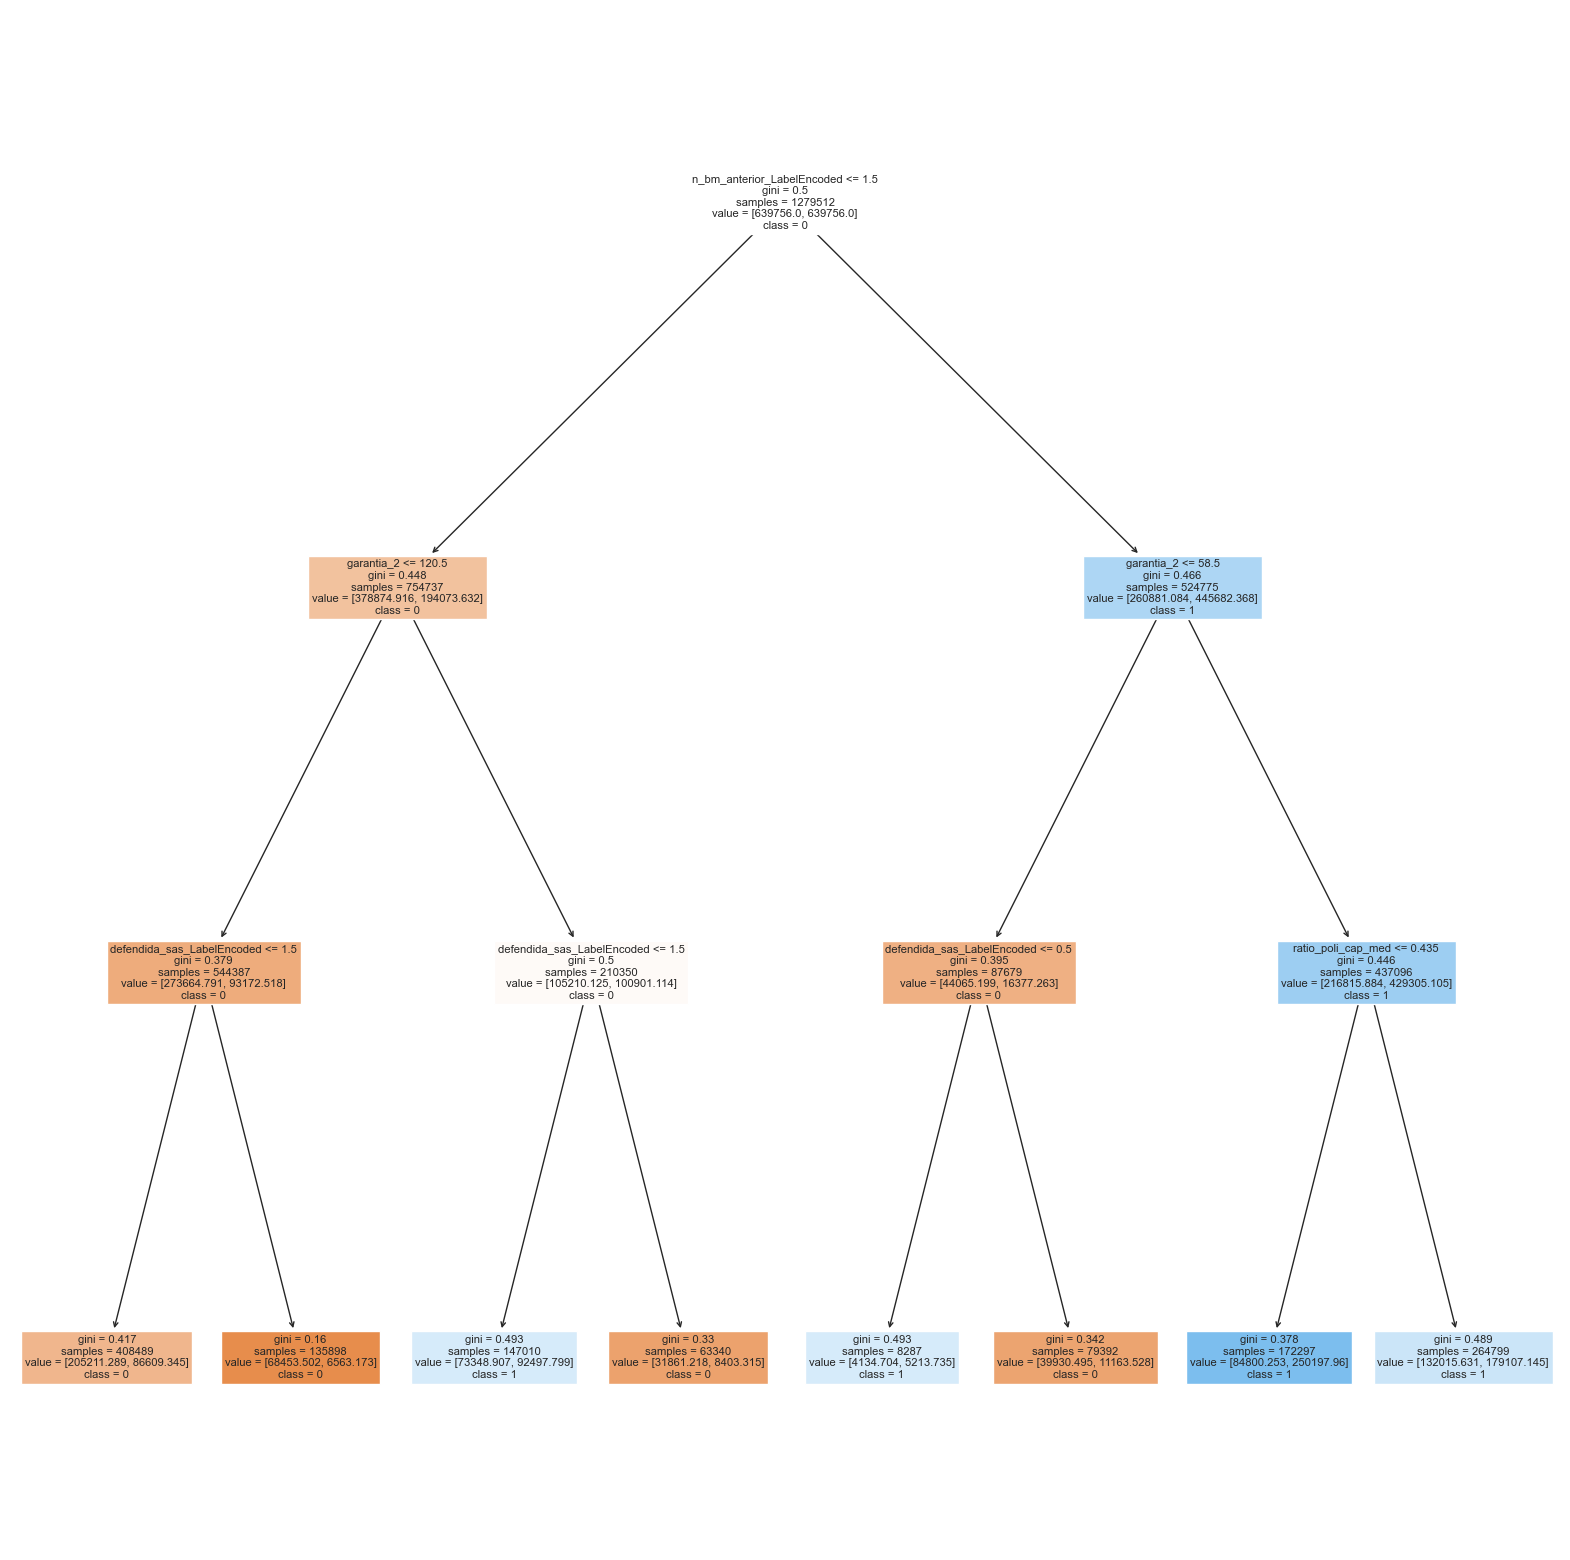

|--- n_bm_anterior_LabelEncoded <= 1.50
|   |--- garantia_2 <= 120.50
|   |   |--- defendida_sas_LabelEncoded <= 1.50
|   |   |   |--- class: 0.0
|   |   |--- defendida_sas_LabelEncoded >  1.50
|   |   |   |--- class: 0.0
|   |--- garantia_2 >  120.50
|   |   |--- defendida_sas_LabelEncoded <= 1.50
|   |   |   |--- class: 1.0
|   |   |--- defendida_sas_LabelEncoded >  1.50
|   |   |   |--- class: 0.0
|--- n_bm_anterior_LabelEncoded >  1.50
|   |--- garantia_2 <= 58.50
|   |   |--- defendida_sas_LabelEncoded <= 0.50
|   |   |   |--- class: 1.0
|   |   |--- defendida_sas_LabelEncoded >  0.50
|   |   |   |--- class: 0.0
|   |--- garantia_2 >  58.50
|   |   |--- ratio_poli_cap_med <= 0.44
|   |   |   |--- class: 1.0
|   |   |--- ratio_poli_cap_med >  0.44
|   |   |   |--- class: 1.0



DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=200, min_weight_fraction_leaf=0,
                       random_state=123456)

In [43]:
decision_tree_model(target = 'frfinal', df_selected = df_encoded_VF, df = DF, min_samples_leaf = 200, max_depth = 3)

#### Label Encoder

In [50]:
total_count = df_encoded_all['frfinal'].value_counts()

filters = [
    df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5,
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 58.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 58.5) & (df_encoded_all['ratio_poli_cap_med'] <= 0.435),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 58.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.435),    
    (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] <= 58.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 0.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 1.5) & (df_encoded_all['garantia_2'] >= 120.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 1.5)    
]

data = {
    'FR': [],
    'No_FR': [],
    '% BBDD FR': [],
    '% BBDD No_FR': []
}

for filter in filters:
    filtered_df = df_encoded_all[['frfinal']][filter]
    value_counts = filtered_df['frfinal'].value_counts()

    data['FR'].append(value_counts.get(1.0, 0))
    data['No_FR'].append(value_counts.get(0.0, 0))
    data['% BBDD FR'].append((value_counts.get(1.0, 0) / total_count.get(1.0, 0)) * 100)
    data['% BBDD No_FR'].append((value_counts.get(0.0, 0) / total_count.get(0.0, 0)) *100)

# Create the DataFrame
FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Hoja2', 'Hoja1', 'Hoja4', 'Hoja6'])

print(FR_df)

         FR   No_FR  % BBDD FR  % BBDD No_FR
Rama1  9076  646612  69.617243     40.760915
Rama2  8751  537622  67.124338     33.890439
Hoja2  5108  209875  39.180793     13.230031
Hoja1  3643  327747  27.943545     20.660408
Hoja4   107   10208   0.820741      0.643489
Hoja6  1890  181516  14.497200     11.442346


In [49]:
df_encoded['paquete_reporting'][df_encoded.paquete_reporting_LabelEncoded <= 2.5].value_counts()

paquete_reporting
121-Basico + Robo    705761
112-Basico           450997
111-Terceros          13823
Name: count, dtype: int64

### Prueba con Variables Numericas

In [56]:
Prueba_Numeric = df_selected.drop(categorical_vars1, axis=1)

Accuracy: 0.8217289091466121
AUC: 0.9249843563944686
F1 score: 0.08377383955397741
F2 score: 0.5184522643334496


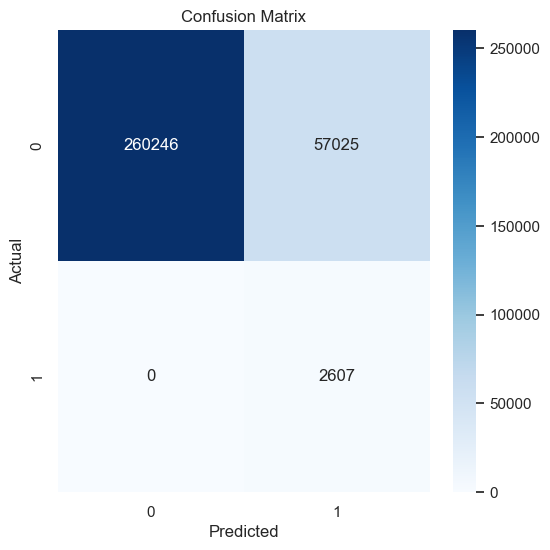

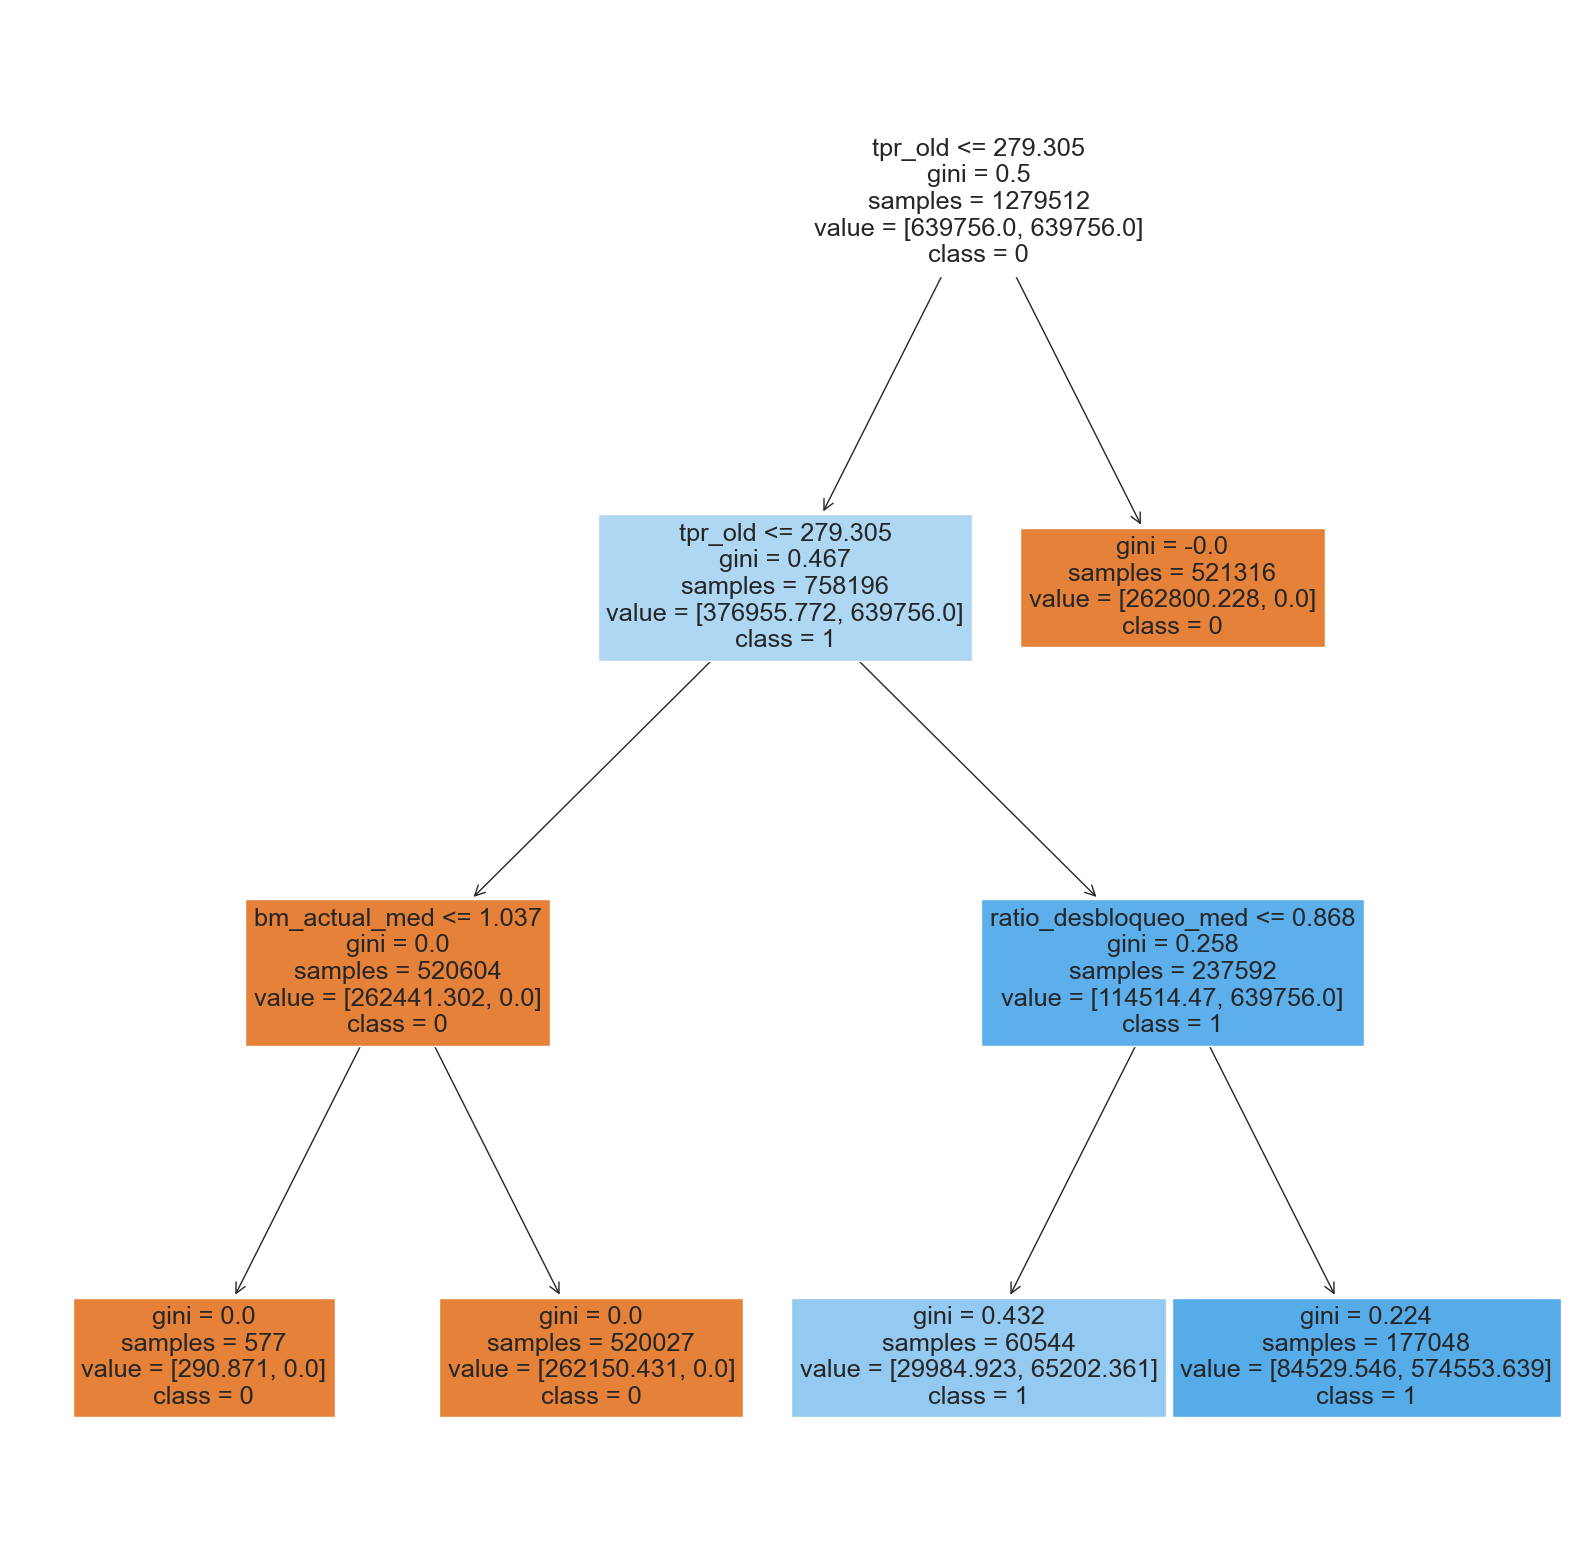

|--- tpr_old <= 279.30
|   |--- tpr_old <= 279.30
|   |   |--- bm_actual_med <= 1.04
|   |   |   |--- class: 0.0
|   |   |--- bm_actual_med >  1.04
|   |   |   |--- class: 0.0
|   |--- tpr_old >  279.30
|   |   |--- ratio_desbloqueo_med <= 0.87
|   |   |   |--- class: 1.0
|   |   |--- ratio_desbloqueo_med >  0.87
|   |   |   |--- class: 1.0
|--- tpr_old >  279.30
|   |--- class: 0.0



ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [57]:
decision_tree_model(target = 'frfinal', df_selected = Prueba_Numeric, df = DF, min_samples_leaf = 210, max_depth = 3)

#### Label Encoder

In [60]:
df_encoded[df_encoded.Retention >= 0.763]

,Priman_New_FR,Codmedp,Modelo,Priman,Tech_Price,Stros2,Bm_Cat,Garantia_2,Pol_Vida,Garantia_3,Agente,Sucursal,Garantia_5,Bm_Anualidad,Edad_Conductor,DC,Provincia,Valor_Vh,Antiguedad_Vehiculo,Retention,Segmento_Deficiente_Bnd,N_Ant,Sdad_Total_Tom,Cilindrada,Paq_Reporting,Stros2_LabelEncoded,N_Ant_LabelEncoded,Codmedp_LabelEncoded,Bm_Cat_LabelEncoded,Bm_Anualidad_LabelEncoded,Paq_Reporting_LabelEncoded,Sucursal_LabelEncoded,Segmento_Deficiente_Bnd_LabelEncoded,Pol_Vida_LabelEncoded,DC_LabelEncoded,Provincia_LabelEncoded,Agente_LabelEncoded,Modelo_LabelEncoded
1,296.769989,6150157,KANGOO COMBI EXPRE 1.9DCI,229.089996,162.687134,999 - NaN,999 - NaN,0,999 - NaN,0,6150157,615,0,999 - NaN,62.0,26,13,16626,21,0.769500,Resto,1,0.000000,1870,112.0,0,1,5668,0,0,1,47,28,0,4,12,8646,28539
8,296.769989,6421601,TOURNEO CONNECT 1.8TDCI 2,490.390015,297.962097,999 - NaN,999 - NaN,0,999 - NaN,0,6421601,642,0,999 - NaN,67.0,24,17,15350,15,0.819519,Resto,1,0.000000,1753,211.0,0,1,5949,0,0,4,51,28,0,3,16,8954,46553
12,296.769989,6150901,DOBLO 1.9 D PANORAMA ELX,174.440002,127.362488,999 - NaN,999 - NaN,0,999 - NaN,0,6150901,615,0,999 - NaN,65.0,26,13,12943,21,0.775106,Resto,1,0.000000,1910,112.0,0,1,5673,0,0,1,47,28,0,4,12,8651,18965
16,296.769989,1320004,TRAFIC COMBI6 (TB33) 5P 6,425.040009,217.845306,999 - NaN,999 - NaN,0,999 - NaN,0,5111962,511,0,999 - NaN,72.0,28,3,15449,24,0.790302,Resto,1,0.000000,2068,112.0,0,1,412,0,0,1,25,28,0,6,29,7441,46617
18,296.769989,682042,LACETTI 1.6 SX 5P 109CV,339.200012,176.038589,999 - NaN,999 - NaN,0,999 - NaN,0,6820420,590,0,999 - NaN,59.0,28,46,14500,17,0.777397,Resto,1,16.559999,1598,121.0,0,1,6129,0,0,2,44,28,0,6,45,9153,29442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856021,296.769989,535016,307 CC 2.0 HDI 136 2P 136,289.000000,284.620605,999 - NaN,999 - NaN,109,999 - NaN,109,5350160,535,0,999 - NaN,64.0,22,34,27830,6,0.770157,Resto,1,0.000000,1997,121.0,0,1,4899,0,0,2,33,28,0,1,33,7854,2374
1856047,296.769989,4700451,JUKE N-CONNECTA 1.2 DIG-T,771.989990,597.491089,999 - NaN,999 - NaN,165,999 - NaN,245,4700451,470,243,999 - NaN,57.0,21,32,20100,5,0.784163,Resto,6,130.210007,1197,213.0,0,6,4286,0,0,6,18,28,0,0,31,7191,27955
1856055,296.769989,600183,ECOSPORT 1.5 TDCI 90 5P 9,334.690002,485.749176,999 - NaN,999 - NaN,128,999 - NaN,201,600183,128,0,999 - NaN,49.0,24,8,19500,8,0.819434,Die.BM>=2.NM>4.Anu>2,5,683.880005,1499,121.0,0,5,5511,0,0,2,5,15,0,3,55,5708,20377
1856084,296.769989,3900027,BERLINGO FGN 1.6 BHDI 75,540.979980,581.278687,999 - NaN,999 - NaN,103,999 - NaN,128,3900027,700,0,999 - NaN,61.0,29,41,15861,8,0.805457,Die.BM>=2.M.Anu>2,5,5.820000,1560,121.0,0,5,3986,0,0,2,59,6,0,7,40,6939,10796


### Prueba sin las Variables en el 1º Arbol

In [48]:
df_encoded_VF1.columns

Index(['priman', 'ratio_diferente_cp_med', 'garantia_2', 'tpr_old', 'apr_old',
       'bm_actual_med', 'canc_impag_rw_med', 'sdad_total_tom',
       'ratio_desbloqueo_med', 'ratio_defensa_med', 'desbloqueo_med',
       'ratio_poli_cap_med', 'garantia_4', 'sinocu', 'edad_conductor',
       'desv_poli_vc_med', 'dcto_coti_cap_med', 'ratio_tirea_no_deseado_med',
       'danos_LabelEncoded', 'segmento_deficiente_bnd_LabelEncoded',
       'cltv_decile_LabelEncoded', 'n_ant_LabelEncoded',
       'provincia_LabelEncoded', 'agente_LabelEncoded', 'marca_LabelEncoded',
       'frfinal'],
      dtype='object')

In [52]:
#Vars = ['modelo_LabelEncoded', 'nombre_med_LabelEncoded', 'priman_new_fr', 'ratio_desbl_falsoreemp_med', 'desbl_falsoreemp_med',
#       'desv_desbl_falsoreemp_med']
Vars = ['tpr_old', 'apr_old']

Prueba_1 = df_encoded_VF1.drop(Vars, axis=1)

Accuracy: 0.5763416052369966
AUC: 0.728473382437635
F1 score: 0.029212662163227
F2 score: 0.34849644460404683


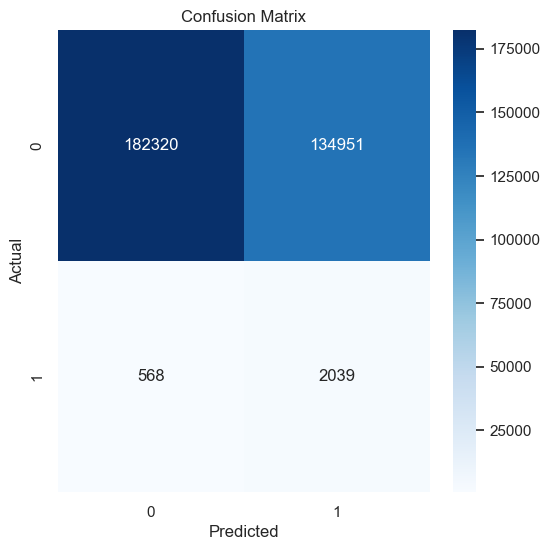

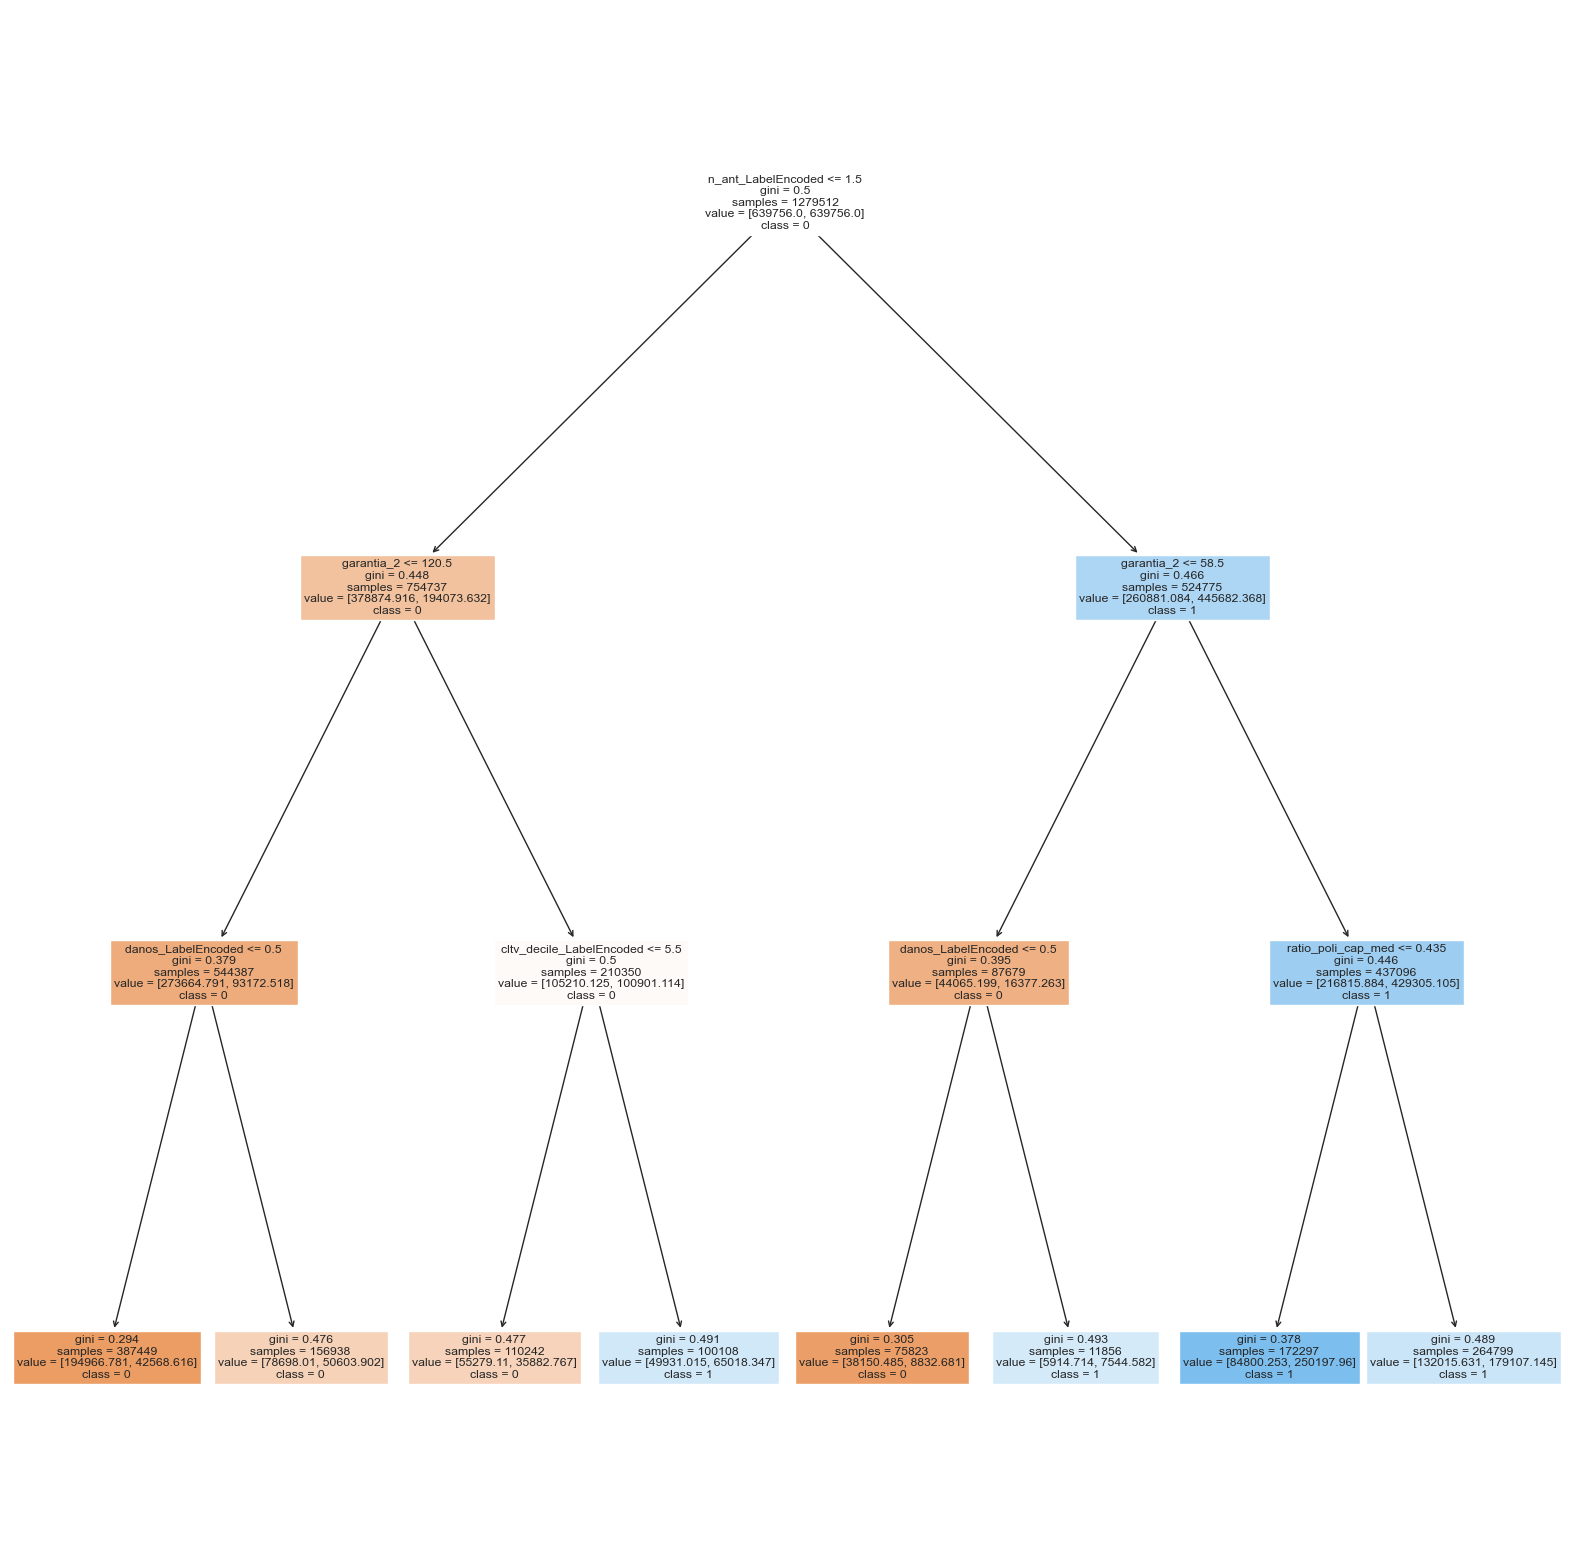

|--- n_ant_LabelEncoded <= 1.50
|   |--- garantia_2 <= 120.50
|   |   |--- danos_LabelEncoded <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- danos_LabelEncoded >  0.50
|   |   |   |--- class: 0.0
|   |--- garantia_2 >  120.50
|   |   |--- cltv_decile_LabelEncoded <= 5.50
|   |   |   |--- class: 0.0
|   |   |--- cltv_decile_LabelEncoded >  5.50
|   |   |   |--- class: 1.0
|--- n_ant_LabelEncoded >  1.50
|   |--- garantia_2 <= 58.50
|   |   |--- danos_LabelEncoded <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- danos_LabelEncoded >  0.50
|   |   |   |--- class: 1.0
|   |--- garantia_2 >  58.50
|   |   |--- ratio_poli_cap_med <= 0.44
|   |   |   |--- class: 1.0
|   |   |--- ratio_poli_cap_med >  0.44
|   |   |   |--- class: 1.0

Nodo: 14, Accuracy: 0.010842757459095284, F2 Score: 0.051960219083309306, AUC: 0.5, F1 Score: 0.02145290625883333
Nodo: 4, Accuracy: 0.9947022195440394, F2 Score: 0.0, AUC: 0.5, F1 Score: 0.0
Nodo: 6, Accuracy: 0.9944850255661066, F2 Score: 0.0, AUC: 0.5, F1 Sc

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=300, min_weight_fraction_leaf=0,
                       random_state=123456)

In [55]:
decision_tree_model(target = 'frfinal', df_selected = Prueba_1, df = DF, min_samples_leaf = 300, max_depth = 3)

In [80]:
df_fr = df_encoded.copy()
print(len(df_fr.columns))

203


In [84]:
df_fr.frfinal.value_counts()

frfinal
0.0    1586353
1.0      13037
Name: count, dtype: int64

In [86]:
df_fr[['frfinal']][df_fr.n_ant_LabelEncoded >= 1.5].value_counts()

frfinal
0.0        646612
1.0          9076
Name: count, dtype: int64

In [87]:
df_fr[['frfinal']][df_fr.n_ant_LabelEncoded <= 1.5].value_counts()

frfinal
0.0        939741
1.0          3961
Name: count, dtype: int64

In [88]:
df_fr[['frfinal']][df_fr.garantia_2 <= 58.5].value_counts()

frfinal
0.0        414913
1.0          1455
Name: count, dtype: int64

#### Label Encoder

In [95]:
df_encoded['n_ant'][df_encoded.n_ant_LabelEncoded <= 1.5].value_counts()

n_ant
1    943699
0         3
Name: count, dtype: int64

In [47]:
df_encoded['Bm_Cat'][df_encoded.Bm_Cat_LabelEncoded <= 0.5].unique()

['999 - NaN']
Categories (7, object): ['999 - NaN', 'A', 'B', 'C', 'D', 'Z', 'ZZ']

In [60]:
df_encoded['Stros2'][df_encoded.Stros2_LabelEncoded <= 0.5].value_counts()

Stros2
999 - NaN         1352818
Con siniestros          0
Sin siniestros          0
Name: count, dtype: int64

In [61]:
df_encoded['Stros2_LabelEncoded'].value_counts()

Stros2_LabelEncoded
0    1352818
2     233820
1      14701
Name: count, dtype: int64

In [64]:
DF_f = df[df.FRFINAL == 1]

In [65]:
DF_f.groupby(['FRFINAL', 'APTP_vf']).size().reset_index(name='count').sort_values(by="count", ascending=False)

,FRFINAL,APTP_vf,count
72,1.0,1.12,189
67,1.0,1.07,176
66,1.0,1.06,174
64,1.0,1.04,174
75,1.0,1.15,171
...,...,...,...
166,1.0,2.06,1
1,1.0,0.40,1
4,1.0,0.44,1
2,1.0,0.42,1


In [ ]:
## Check

In [54]:
value_to_check = '999 - NaN'

columns_with_value = df_encoded_VF.apply(lambda column: value_to_check in column.values)

try:
    columns_with_value_true = columns_with_value[columns_with_value].index.tolist()
except ValueError:
    columns_with_value_true = columns_with_value[columns_with_value].apply(
        lambda x: np.nan if isinstance(x, str) and x != value_to_check else x
    ).dropna(how='all').index.tolist()

print(columns_with_value_true)

['Class_Anul', 'Motanul', 'Priman_New_FR', 'Defendible', 'IsBMP', 'Defendida_Ant', 'Bm_Cat']
